# Notebook Instructions
<i>You can run the notebook document sequentially (one cell at a time) by pressing <b> shift + enter</b>. While a cell is running, a [*] will display on the left. When it has been run, a number will display indicating the order in which it was run in the notebook [8].</i>

<i>Enter edit mode by pressing <b>`Enter`</b> or using the mouse to click on a cell's editor area. Edit mode is indicated by a green cell border and a prompt showing in the editor area.</i>

## Neural Network

In this notebook, we will use sklearn's MLPClassifier to create a trading strategy using the neural network. We will
follow the below steps.

1. Import the data
2. Define predictors and target variables
3. Split the data into train and test dataset
4. Scale the data
5. Create a neural network using the train data
6. Analyze the performance

### Import the data

We import the data of Boeing Co (ticker: BA) from the csv file.

In [1]:
import pandas as pd
data = pd.read_csv('BA.csv',index_col=0)
data.index = pd.to_datetime(data.index)
data.tail(3)

,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume
Date,,,,,,,,,,,,
2018-04-11,331.60,337.57,326.31,327.36,4566253.0,0.0,1.0,329.960125,335.900601,324.696286,325.741093,4566253.0
2018-04-12,331.98,338.35,330.46,337.48,4318083.0,0.0,1.0,330.338246,336.676744,328.825763,335.811046,4318083.0
2018-04-13,338.99,339.67,326.60,329.28,4730972.0,0.0,1.0,337.313579,337.990216,324.984852,327.651598,4730972.0


### Define predictor variables and a target variable

We define a list of predictors as listed below 
1. ret1 is the one-day returns, 
2. ret5 is the five-day returns, 
3. std5 is the five-day standard deviation, 
4. volume_by_adv20 is the volume divided by the 20-days average of daily volume and 
5. price differences (High - Low) and (Open - Close). <BR>

Syntax:
1. <font color='blue'>pct_change()</font> computes the percentage change from the immediately previous row by default.
2. <font color='blue'>rolling_sum(dataframe.column_name, window=n)</font> computes the sum of previous n rows.
3. <font color='blue'>rolling_std(dataframe.column_name, window=n)</font> computes the standard deviation of previous n rows.

In [2]:
# Returns
data['ret1'] = data['Adj_Close'].pct_change()
data['ret5'] = pd.rolling_sum(data.ret1, 5)

# Standard Deviation
data['std5'] = pd.rolling_std(data.ret1, 5)

# Volume by ADV20
data['volume_by_adv20'] = data.Adj_Volume/pd.rolling_mean(data.Adj_Volume,20)

# High - low
data['H-L'] = data['Adj_High'] - data['Adj_Low']

# Open - Close
data['O-C'] = data['Adj_Close'] - data['Adj_Open']

We define the target variable which is the future one-day returns. <BR>

Syntax:
<font color='blue'>shift(periods=n)</font> shifts the values by n period(s). If the value of n is negative then, it shifts the values backward and vice-versa.

In [3]:
# Future returns
data['retFut1'] = data.ret1.shift(-1)

We drop the NaN values and store the predictor variables in X and target variable in y. The target variable is 
- 1.0 if the one-day future returns are positive and 
- 0 if the returns are negative or zero.

In [4]:
# Define predictor variables (X) and a target variable (y)
data = data.dropna()
predictor_list = ['H-L','O-C','ret5', 'std5','volume_by_adv20']
X = data[predictor_list]

import numpy as np
y = np.where(data.retFut1 > 0.0, 1.0, 0)

### Split the data into train and test dataset

This step is required to verify if the neural network we will create is any good. We will split the dataset into two parts, first 80% of the dataset will be used to create the model and the remaining 20% will be used as a test dataset.

In [5]:
# Split the data into train and test dataset
from sklearn.model_selection import train_test_split

train_length = int(len(data)*0.80)

X_train = X[:train_length] 
X_test =  X[train_length:]

y_train = y[:train_length]
y_test = y[train_length:]    

Often, there is a regime change in time series data, so that a model trained on data randomly selected through the dataset will outperform a model trained on data selected from an earlier part of the data, but the latter will be more realistic. Also, if we are forced to select from an earlier part of the data, there is no way to ensure that the statistics of the train and test set are the same (i.e. equal % of classes in each), but that again is realistic. In trading applications, we normally don't have truly stationary statistics, and a ML strategy needs to be robust enough to withstand that.

### Scale the data

In this step, we standardize the features stored in X using sklearn's StandardScaler function. The machine learning model might behave in unexpected fashion if the individual predictors are not standardized.

The StandardScaler function standardizes the predictors by removing the mean and scaling to unit variance.

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Create the scaler model using train data
scaler.fit(X_train)

# Transform the training and test data using the scaler model created above
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Create a neural network model

The MLPClassifier function from the sklearn.neural_network package is used to create a neural network model. The MLPClassifier takes following as input parameter
1. <b>activation:</b> The activation function such as logistic regression can be used to define the output from the neurons.
2. <b>hidden_layer_sizes:</b> A tuple to specify the number of hidden layers and number of neurons in each of the hidden layers. For example, the tuple (2,5) indicates two hidden layers with 2 neurons in the first layer and 5 neurons in the second layer.
3. <b>random_state:</b> It is used to initialize the weights and bias.
4. <b>solver:</b> A function such as stochastic gradient descent is used to optimize the weights during backpropagation. 'sgd' is specified to indicate 'stochastic gradient descent'. For the full list of functions type help(MLPClassifier).

In [7]:
# Import the MLPClassifier
from sklearn.neural_network import MLPClassifier
# Uncomment below line to see details of MLPClassifier
# help(MLPClassifier)

In [8]:
# seed is initialized to 42
seed = 42
# Create the MLPClassifier model
mlp = MLPClassifier(activation='logistic', hidden_layer_sizes=(5), random_state=seed, solver='sgd')

### Training the model

The fit function is used to train the model using the train dataset which is stored in X_train and y_train. The parameters to the fit function are the predictor variables and target variable.

In [9]:
# Fit the model on train dataset
mlp.fit(X_train, y_train)

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=5, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='sgd', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [10]:
# Uncomment below line to see details of MLPClassifier
# help(MLPClassifier)

## Predict using the neural network

We define a trading rule based on the predicted value from the neural network. If the predicted value is positive then we buy (+1) the stock and otherwise, we don't buy the stock. This signal is stored in predicted_signal. The strategy returns are generated by multiplying the future one-day returns by the predicted signal and stored in the strategy_returns_nn. 

In [11]:
data['predicted_signal'] = mlp.predict(X)
data['strategy_returns_nn'] = data.retFut1 * data.predicted_signal
data.tail(3)

,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,...,Adj_Volume,ret1,ret5,std5,volume_by_adv20,H-L,O-C,retFut1,predicted_signal,strategy_returns_nn
Date,,,,,,,,,,,,,,,,,,,,,
2018-04-10,331.35,336.69,329.55,334.83,5616231.0,0.0,1.0,329.711361,335.024953,327.920263,...,5616231.0,0.038297,0.013723,0.028899,0.873983,7.104690,3.462790,-0.022310,0.0,-0.0
2018-04-11,331.60,337.57,326.31,327.36,4566253.0,0.0,1.0,329.960125,335.900601,324.696286,...,4566253.0,-0.022310,0.001631,0.030704,0.715461,11.204315,-4.219032,0.030914,0.0,0.0
2018-04-12,331.98,338.35,330.46,337.48,4318083.0,0.0,1.0,330.338246,336.676744,328.825763,...,4318083.0,0.030914,0.005181,0.031516,0.726307,7.850981,5.472801,-0.024298,0.0,-0.0


## Performance of the neural network

### Sharpe Ratio

The Sharpe ratio is calculated as follows:

<img src="https://d2a032ejo53cab.cloudfront.net/Glossary/R2TAJa6K/Sharpe-1.jpg"></img>

Where
- N is the number of trading days in a year
- Rf is the risk-free rate
- Std dev is the standard deviation

Sharpe ratio represents how good the strategy performance is for the risk (standard deviation) taken to achieve it. The higher the Sharpe ratio the better is the strategy. Generally, a Sharpe ratio of greater than 1.5 is preferred.

In [12]:
# The below function returns the Sharpe ratio for the excess returns (Strategy returns - Risk free rate) passed to it.
def annualized_sharpe_ratio(returns, N=252):
    return np.sqrt(N) * returns.mean() / returns.std()

We calculate the Sharpe ratio for the strategy in train and test dataset. The risk-free rate is assumed to be 5% p.a.

In [13]:
# Sharpe ratio
# Train dataset
data['excess_daily_strategy_return'] = data.strategy_returns_nn - 0.05/252
sharpe_train_nn = annualized_sharpe_ratio(data.excess_daily_strategy_return.iloc[:train_length])
# Test dataset
sharpe_test_nn = annualized_sharpe_ratio(data.excess_daily_strategy_return.iloc[train_length:])

### Strategy CAGR
CAGR represents the compounded annual returns of the strategy. The strategy CAGR is computed as follows:

<i>(Cumulative returns + 1)^(252/number of days) - 1</i>

where cumulative returns are the total strategy returns and number of days represent the total trading days.

In [14]:
def CAGR(returns):
    cumulative_returns = returns.cumsum().iloc[-1]   
    period_in_days = len(returns)
    return 100*((cumulative_returns+1)**(252.0/period_in_days)-1)

We compute the strategy CAGR in train and test dataset.

In [15]:
# CAGR
# Train dataset
ret_train_nn = CAGR(data.strategy_returns_nn.iloc[:train_length])
# Test dataset
ret_test_nn = CAGR(data.strategy_returns_nn.iloc[train_length:])

#### Plot cumulative returns in train dataset

In [16]:
import matplotlib.pyplot as plt
import seaborn

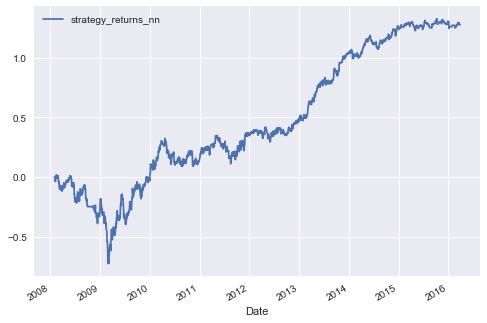

In [17]:
# Plot the cumulative returns for neural network in train dataset
data.strategy_returns_nn[:train_length].cumsum().plot()

# Show the legend
plt.legend()

# Show the graph
plt.show()

#### Plot cumulative returns in test dataset

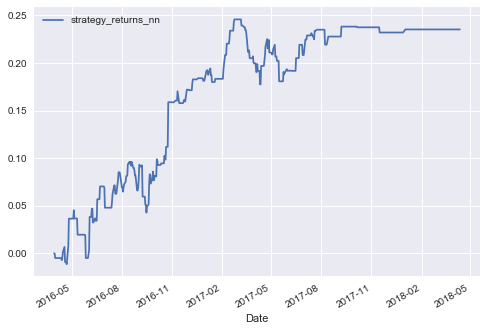

In [18]:
# Plot the cumulative returns for neural network in test dataset
data.strategy_returns_nn[train_length:].cumsum().plot()

# Show the legend
plt.legend()

# Show the graph
plt.show()

#### Strategy Results

In [19]:
from tabulate import tabulate

print tabulate(
        [             
            ['CAGR', ret_train_nn, ret_test_nn],
            ['Sharpe Ratio', sharpe_train_nn, sharpe_test_nn],
        ], 
        headers=['Train', 'Test'], 
    tablefmt='orgtbl')

|              |    Train |      Test |
|--------------+----------+-----------|
| CAGR         | 10.6044  | 10.9185   |
| Sharpe Ratio |  0.44056 |  0.711128 |


#### Accuracy of the neural network classifier

The classification_report function from sklearn.metrics package is used to analyze the performance of the neural network. The classification_report takes as input the actual output and the predicted output.

In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_test,mlp.predict(X_test)))

             precision    recall  f1-score   support

        0.0       0.46      0.51      0.49       216
        1.0       0.62      0.57      0.59       298

avg / total       0.55      0.55      0.55       514



The output of classification report
1. <B>Precision</B>: tp / (tp + fp) 
<BR>where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
2. <B>Recall</B>: tp / (tp + fn) 
<BR> where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.
3. <B>F1-score</B>: It can be interpreted as a weighted harmonic mean of the precision and recall, The F1-score reaches its best value at 1 and worst score at 0. 
5. <B>Support</B>: It is the number of occurrences of each class in y_true.

In this notebook, we created a very simple neural network. Coming up next, a short quiz and interactive exercise on neural network and in next section, a trading strategy using a deep neural network. Keep learning!